In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
data_path = '/Users/shalinimanna/Documents/CVND/hour.csv'
rides = pd.read_csv(data_path)
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


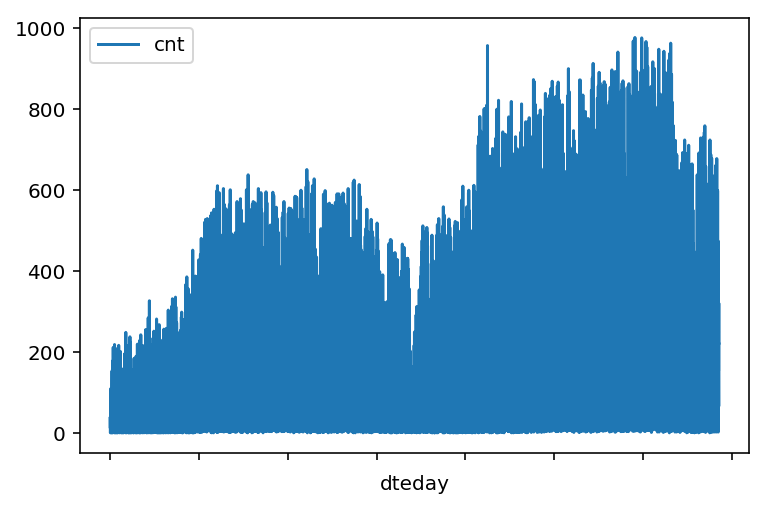

In [3]:
rides[:-24*10].plot(x='dteday',y='cnt')

In [4]:
#creating dummy variables to quantify categorical vars
dummy_fields = ['season','weathersit','mnth','weekday','hr']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each],prefix=each,drop_first=False)
    rides=pd.concat([rides,dummies],axis=1)
fields_to_drop = ['instant','dteday','season','weathersit','workingday','hr','mnth','atemp','weekday']
data = rides.drop(fields_to_drop,axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_14,hr_15,hr_16,hr_17,hr_18,hr_19,hr_20,hr_21,hr_22,hr_23
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
#scaling target variables
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

In [6]:
#LAST 21 days of data is the test set
test_data = data[-21*24:]
data=data[:-21*24]
target_fields = ['cnt','casual','registered']
features, targets = data.drop(target_fields,axis=1),data[target_fields]
test_features,test_targets = test_data.drop(target_fields,axis=1),test_data[target_fields]

In [7]:
#last 60 days of rem data set as a validation set
train_features, train_targets = features[:-60*24],targets[:-60*24]
val_features,val_targets = features[-60*24:],targets[-60*24:]

In [12]:
class NeuralNetwork(object):
    def __init__(self,input_nodes,hidden_nodes,output_nodes,learning_rate):
        self.input_nodes = input_nodes
        self.output_nodes = output_nodes
        self.hidden_nodes = hidden_nodes
        
        #initializing the weights
        self.weights_inputs_to_hidden = np.random.normal(0.0,self.hidden_nodes**-0.5,
                                                        (self.hidden_nodes,self.input_nodes))
        self.weights_hidden_to_output = np.random.normal(0.0, self.output_nodes**-0.5, 
                                       (self.output_nodes, self.hidden_nodes))
        self.lr = learning_rate
        self.activation_function =  lambda x: 1/(1 + np.exp(-x))
        #lambda x:expression is used when we need an anonymus function for a short time
    def train(self,inputs_list,targets_list):
        #convert to 2d
        inputs=np.array(inputs_list,ndmin=2).T
        targets = np.array(targets_list,ndmin=2).T
        ##Forward Pass##
        #hidden layer
        hidden_inputs = np.dot(self.weights_inputs_to_hidden,inputs)
        hidden_outputs = self.activation_function(hidden_inputs)
        #output layer
        final_inputs = np.dot(self.weights_hidden_to_output,hidden_outputs)
        final_outputs = final_inputs ##f(x)=x
        
        #backward pass
        ##output errors
        output_errors=targets - final_outputs
        #backpropagated error
        hidden_errors = np.dot(self.weights_hidden_to_output.T,output_errors)
        hidden_grad = hidden_outputs*(1-hidden_outputs) #see math behind backprop:h(x)*(1-h(x))
        #partial derivative of sigmoid is sigmoid*(1-sigmoid)
        hidden_err_grad = hidden_errors*hidden_grad
        self.weights_hidden_to_output +=(self.lr*np.dot(output_errors,hidden_outputs.T))
        self.weights_inputs_to_hidden +=(self.lr*np.dot(hidden_err_grad,inputs.T))
        
    def run(self,inputs_list):
        #running a fwd pass thru network
        inputs = np.array(inputs_list,ndmin=2).T
        hidden_inputs = np.dot(self.weights_inputs_to_hidden,inputs)
        hidden_outputs = self.activation_function(hidden_inputs)
        final_inputs = np.dot(self.weights_hidden_to_output,hidden_outputs)
        final_outputs = final_inputs
        return final_outputs

In [13]:
def MSE(y,Y):
    return np.mean((y-Y)**2)

In [14]:
import sys

In [17]:
epochs = 1000
learning_rate = 0.01
hidden_nodes = 56
output_nodes=1
N_i = train_features.shape[1]
network = NeuralNetwork(N_i,hidden_nodes,output_nodes,learning_rate)
losses={'train':[],'validation':[]}
for e in range(epochs):
    #Go thru a random batch of 128 records from training data
    batch = np.random.choice(train_features.index, size=128)
    for record, target in zip(train_features.ix[batch].values,train_targets.ix[batch]['cnt']):
        network.train(record, target)
    train_loss = MSE(network.run(train_features),train_targets['cnt'].values)
    val_loss = MSE(network.run(val_features),val_targets['cnt'].values)
    sys.stdout.write("\rProgress:"+str(100*e/float(epochs))[:4]\
                     +"%...Training loss:"+str(train_loss)[:5]\
                     +"...Validation loss:"+str(val_loss)[:5])
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)
        

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # This is added back by InteractiveShellApp.init_path()


Progress:99.9%...Training loss:0.143...Validation loss:0.276

(0.09094656630139639, 0.5)

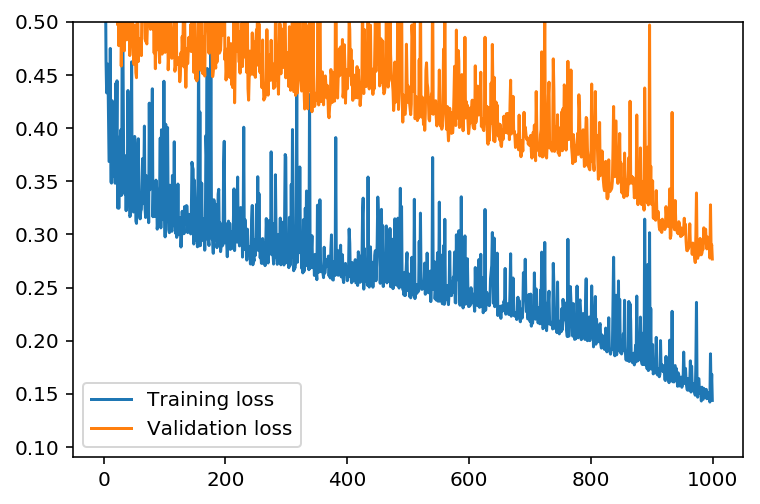

In [19]:
plt.plot(losses['train'],label='Training loss')
plt.plot(losses['validation'],label='Validation loss')
plt.legend()
plt.ylim(ymax=0.5)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.


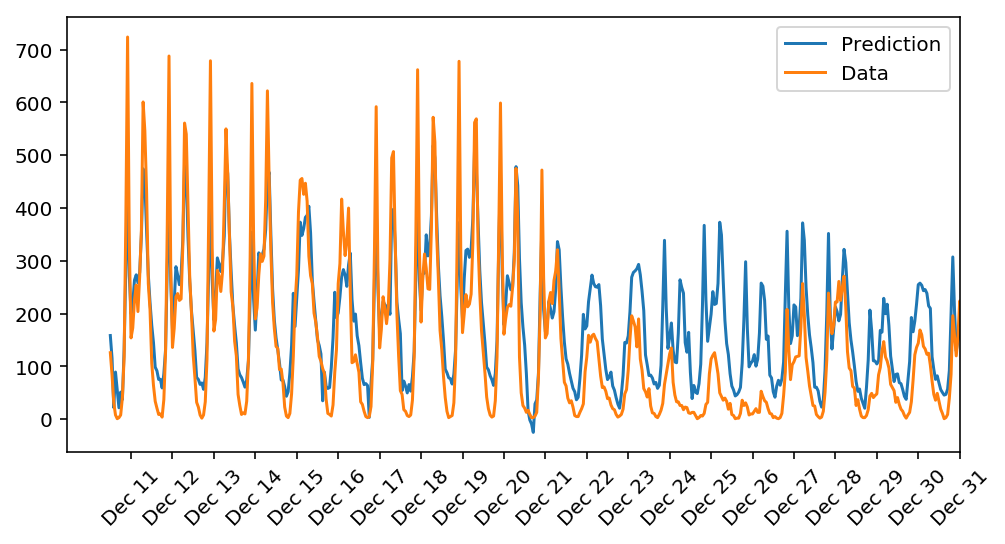

In [20]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features)*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)